In [1]:
import time
import os
import numpy as np
import math
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow.keras import layers, models

tf.get_logger().setLevel('ERROR')

In [2]:
from sklearn.metrics import confusion_matrix
import pandas as pd

In [3]:
!pwd

/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation


# Load data

In [4]:
# DATA_DIR = "./numbers/"
DATA_DIR = "./eval_data//"
CHECKPOINT_PATH = "./models/"
BATCH_SIZE = None
IMG_HEIGHT = 28
IMG_WIDTH = 28
TRAIN_VAL_RATIO = 0.01

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=TRAIN_VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale')

Found 3602 files belonging to 10 classes.
Using 3566 files for training.
Found 3602 files belonging to 10 classes.
Using 36 files for validation.


In [6]:
# # Normalizing the images between 0 and 1
# normalization_layer = tf.keras.layers.Rescaling(1. / 255)
# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# ds_iterator = iter(train_ds)

In [8]:
# im_batch, label_batch = next(ds_iterator)

In [9]:
# data_tuple_list = list(zip(im_batch, label_batch))

In [10]:
# dim = math.ceil(math.sqrt(len(data_tuple_list)))
# rows = dim
# cols = dim
# fig = plt.figure(figsize=[15, 18])

# for i, (img, lbl) in enumerate(data_tuple_list): 
#     # print(lbl)
#     # print(img)
#     ax = plt.subplot(rows, cols, (i + 1))
#     plt.xticks([]) 
#     plt.yticks([]) 
#     plt.imshow(img/255.)
#     plt.title(lbl.numpy())
# plt.show()

In [11]:
import tensorflow_datasets as tfds

In [12]:
# (train_data, train_label), (val_data, val_label) = tf.keras.datasets.mnist.load_data()
# mnist_train_ds = tfds.load('mnist', split='train', shuffle_files=True, )
# mnist_val_ds = tfds.load('mnist', split='test', shuffle_files=True)

In [13]:
# mnist_train_ds = mnist_train_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
# mnist_val_ds = mnist_val_ds.shuffle(1024).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [14]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [15]:
x_train.shape

(60000, 28, 28)

In [16]:
x_train, x_test = np.array(x_train, np.uint8), np.array(x_test, np.uint8)
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1))

y_train = np.array(y_train, np.int64)
y_test = np.array(y_test, np.int64)
# x_train, self.y_train, self.x_val, self.y_val = self.split_data(self.rnd, val_size // 10, self.x_train,
#                                                                      self.y_train)

In [17]:
x_train.shape, x_train.dtype

((60000, 28, 28, 1), dtype('uint8'))

In [18]:
t_data,t_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(train_ds)])
v_data,v_label = zip(*[(a.numpy(),b.numpy()) for a,b in iter(val_ds)])

In [19]:
train_x = np.array(t_data, np.uint8)
train_y = np.array(t_label, np.int64)
test_x = np.array(v_data, np.uint8)
test_y = np.array(v_label, np.int64)

In [20]:
print(train_x.shape, train_y.shape, x_train.shape, y_train.shape)
print(test_x.shape, test_y.shape, x_test.shape, y_test.shape)

(3566, 28, 28, 1) (3566,) (60000, 28, 28, 1) (60000,)
(36, 28, 28, 1) (36,) (10000, 28, 28, 1) (10000,)


In [21]:
con_train_x = np.concatenate((train_x, x_train), axis=0)
con_train_y = np.concatenate((train_y, y_train), axis=0)
con_test_x = np.concatenate((test_x, x_test), axis=0)
con_test_y = np.concatenate((test_y, y_test), axis=0)

In [22]:
print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(3566, 28, 28, 1) (3566,)
(36, 28, 28, 1) (36,)


In [23]:
# idx = np.random.permutation(len(train_x))
# idx = idx[0:32]
# x,y = train_x[idx], train_y[idx]

# dim = math.ceil(math.sqrt(len(x)))
# rows = dim
# cols = dim
# fig = plt.figure(figsize=[15, 18])

# for i, img in enumerate(x): 
#     # print(lbl)
#     # print(img)
#     ax = plt.subplot(rows, cols, (i + 1))
#     plt.xticks([]) 
#     plt.yticks([]) 
#     plt.imshow(img)
#     plt.title(y[i])
# plt.show()

# Define model structure and callback

In [24]:
def create_model():

    resize_and_rescale = tf.keras.Sequential([
      # tf.keras.layers.Resizing(IMG_WIDTH, IMG_HEIGHT),
      tf.keras.layers.Rescaling(1./255)
    ])

    data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomRotation(0.15)
            # tf.keras.layers.RandomContrast(0.5)
        ])
    
    model = models.Sequential()
    model.add(resize_and_rescale)
    model.add(data_augmentation)
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [25]:
cur_time = round(time.time())

# checkpoint_filepath = './local_models/' + str(cur_time) + "/" + 'val_acc_{val_accuracy:.2f}_'
checkpoint_filepath = CHECKPOINT_PATH + str(cur_time) + "/"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# Model training

In [26]:
model = create_model()

In [859]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-4)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [860]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=30,
    batch_size=128,
    shuffle=True
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/30
28/28 [==============================] - 3s 70ms/step - loss: 0.1059 - accuracy: 0.9804 - val_loss: 0.1023 - val_accuracy: 0.9722
Epoch 2/30
28/28 [==============================] - 2s 65ms/step - loss: 0.0539 - accuracy: 0.9865 - val_loss: 0.0707 - val_accuracy: 0.9722
Epoch 3/30
28/28 [==============================] - 2s 67ms/step - loss: 0.0314 - accuracy: 0.9913 - val_loss: 0.0590 - val_accuracy: 0.9722
Epoch 4/30
28/28 [==============================] - 2s 64ms/step - loss: 0.0239 - accuracy: 0.9936 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 5/30
28/28 [==============================] - 2s 64ms/step - loss: 0.0239 - accuracy: 0.9944 - val_loss: 0.1623 - val_accuracy: 0.9722
Epoch 6/30
28/28 [==============================] - 2s 65ms/step - loss: 0.0198 - accuracy: 0.9944 - val_loss: 0.0276 - val_accuracy: 1.0000
Epoch 7/30
28/28 [==============================] - 2s 64ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 8/30
28

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         0         
                                                                 
 sequential_1 (Sequential)   (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                      

In [70]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=10,
    batch_size=128,
    shuffle=True
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/10
496/496 [==============================] - 33s 64ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0353 - val_accuracy: 0.9915
Epoch 2/10
496/496 [==============================] - 32s 64ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0363 - val_accuracy: 0.9924
Epoch 3/10
496/496 [==============================] - 32s 65ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0352 - val_accuracy: 0.9920
Epoch 4/10
496/496 [==============================] - 32s 64ms/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.0359 - val_accuracy: 0.9919
Epoch 5/10
496/496 [==============================] - 32s 64ms/step - loss: 0.0028 - accuracy: 0.9992 - val_loss: 0.0377 - val_accuracy: 0.9920
Epoch 6/10
496/496 [==============================] - 32s 64ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0364 - val_accuracy: 0.9917
Epoch 7/10
496/496 [==============================] - 32s 65ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0386 - val_accuracy:

In [861]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [862]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=10,
    batch_size=256
    # callbacks=[model_checkpoint_callback]
)

Epoch 1/10
14/14 [==============================] - 3s 135ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.1851 - val_accuracy: 0.9722
Epoch 2/10
14/14 [==============================] - 2s 127ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.2001 - val_accuracy: 0.9722
Epoch 3/10
14/14 [==============================] - 2s 126ms/step - loss: 0.0015 - accuracy: 0.9994 - val_loss: 0.2085 - val_accuracy: 0.9722
Epoch 4/10
14/14 [==============================] - 2s 124ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.2111 - val_accuracy: 0.9722
Epoch 5/10
14/14 [==============================] - 2s 123ms/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.1358 - val_accuracy: 0.9722
Epoch 6/10
14/14 [==============================] - 2s 124ms/step - loss: 0.0016 - accuracy: 1.0000 - val_loss: 0.1378 - val_accuracy: 0.9722
Epoch 7/10
14/14 [==============================] - 2s 124ms/step - loss: 9.1074e-04 - accuracy: 0.9997 - val_loss: 0.1672 - val_accuracy: 0.9722
Ep

In [30]:
# softmax = tf.keras.layers.Softmax()

In [31]:
# val_ds = train_ds

In [863]:
model.save_weights('./final12/')

# Load model

In [26]:
model = create_model()
model.load_weights('./final12/')

In [39]:
optimizer = tf.keras.optimizers.Adam(learning_rate=10e-5)
model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [40]:
model.evaluate(train_x, train_y)
model.evaluate(test_x, test_y)

2/2 [==============================] - 0s 3ms/step - loss: 0.1590 - accuracy: 0.9722


[0.15896831452846527, 0.9722222089767456]

In [41]:
history = model.fit(
    train_x, train_y,
    validation_data=(test_x, test_y),
    epochs=5,
    shuffle=True,
    batch_size=256
)

Epoch 1/5
14/14 [==============================] - 3s 126ms/step - loss: 9.4240e-04 - accuracy: 1.0000 - val_loss: 0.1365 - val_accuracy: 0.9722
Epoch 2/5
14/14 [==============================] - 2s 123ms/step - loss: 3.7547e-04 - accuracy: 1.0000 - val_loss: 0.1621 - val_accuracy: 0.9722
Epoch 3/5
14/14 [==============================] - 2s 121ms/step - loss: 6.7328e-04 - accuracy: 1.0000 - val_loss: 0.2060 - val_accuracy: 0.9722
Epoch 4/5
14/14 [==============================] - 2s 124ms/step - loss: 9.0707e-04 - accuracy: 0.9997 - val_loss: 0.2172 - val_accuracy: 0.9722
Epoch 5/5
14/14 [==============================] - 2s 124ms/step - loss: 5.7810e-04 - accuracy: 1.0000 - val_loss: 0.2145 - val_accuracy: 0.9722


In [42]:
# model.save_weights('./final7/')

In [43]:
# np.argmax(all_class_prediction)

In [44]:
# np.argsort(all_class_prediction)[-1]

# Model evaluation

## Plot train_ds

In [45]:
# prediction = model.predict(train_ds)
# model.evaluate(train_ds)

# images, labels = zip(*[(x, y) for x, y in train_ds])
# labels = np.concatenate(labels, axis=0)
# images = np.concatenate(images, axis=0)
# print(labels.shape, type(prediction))

# wrongs = np.where(np.equal(predictions, labels) == False)[0]
# wrongs

## Plot test_x

In [46]:
images, labels = test_x, test_y

In [47]:
# prediction = model.predict(train_ds)
# model.evaluate(train_ds)

prediction = model.predict(images)
model.evaluate(images,labels)

all_class_predictions = prediction
predictions = np.argmax(prediction, axis=1)
print(predictions.shape, type(prediction))

wrongs = np.where(np.equal(predictions, labels) == False)[0]
print(wrongs)

2/2 [==============================] - 0s 6ms/step - loss: 0.2145 - accuracy: 0.9722
(36,) <class 'numpy.ndarray'>
[20]


In [48]:
len(all_class_predictions), len(predictions), len(labels), len(images)

(36, 36, 36, 36)

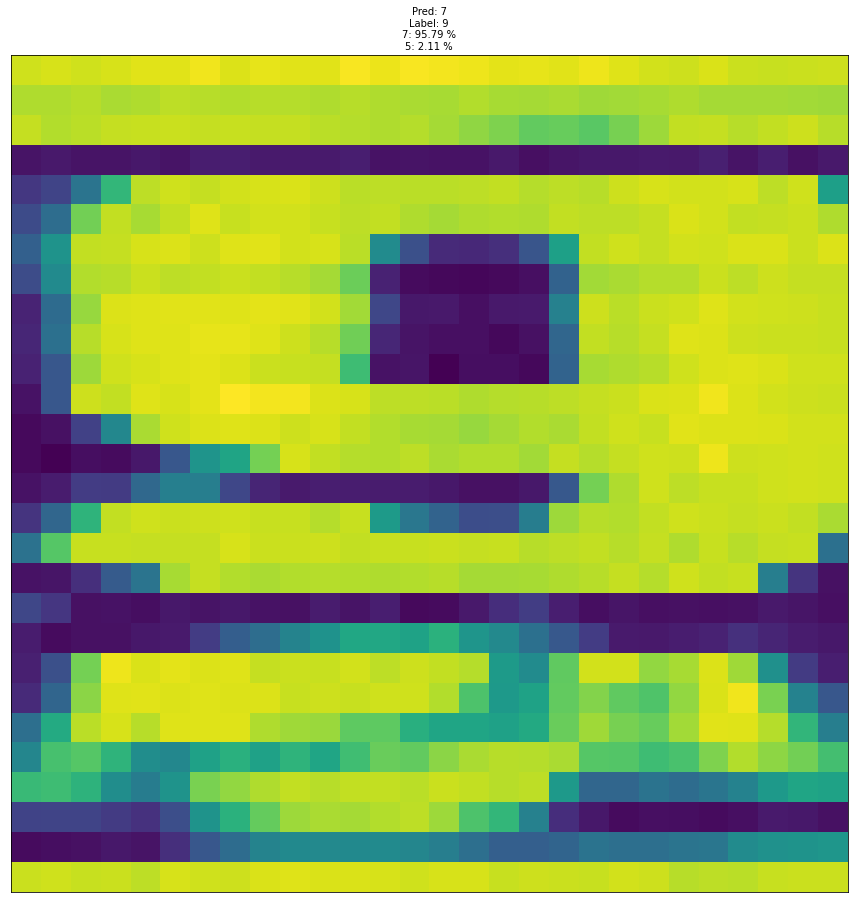

In [49]:
tup = np.asarray(list(zip(all_class_predictions, predictions, labels, images)), dtype=object)
tup = tup[wrongs]

dim = math.ceil(math.sqrt(len(tup)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, (all_class_prediction, prediction, label, img) in enumerate(tup): 
    ax = plt.subplot(rows, cols, (i + 1))
    # ax.get_yaxis().set_visible(False)
    # ax.get_xaxis().set_visible(False)
    # ax.get_xlabel().set_visible_visible(True)
    # ax.set_xlabel()
    # disabling xticks by Setting xticks to an empty list
    plt.xticks([]) 

    # disabling yticks by setting yticks to an empty list
    plt.yticks([]) 
    plt.imshow(img/255.)
    # plt.axis('off')
    plt.title("Pred: " + str(prediction) + "\n" + "Label: " + str(label) + "\n" +
             str(np.argsort(all_class_prediction)[-1]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-1], 2)) + " %" + "\n" + 
             str(np.argsort(all_class_prediction)[-2]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-2], 2))  + " %", fontsize=10)
    # print(softmax(all_class_prediction))
    # print(str(round(np.max(all_class_prediction) * 100, 2)) + " %")
    # plt.xlabel("Pred: " + str(prediction) + " " + "Label: " + str(label), fontsize=8)
plt.show()

## Plot train_x

In [50]:
images, labels = train_x, train_y

In [51]:
prediction = model.predict(images)
model.evaluate(images,labels)

all_class_predictions = prediction
predictions = np.argmax(prediction, axis=1)
print(predictions.shape, type(prediction))

wrongs = np.where(np.equal(predictions, labels) == False)[0]
print(wrongs)

112/112 [==============================] - 1s 5ms/step - loss: 0.0010 - accuracy: 0.9997
(3566,) <class 'numpy.ndarray'>
[1260]


In [52]:
len(all_class_predictions), len(predictions), len(labels), len(images)

(3566, 3566, 3566, 3566)

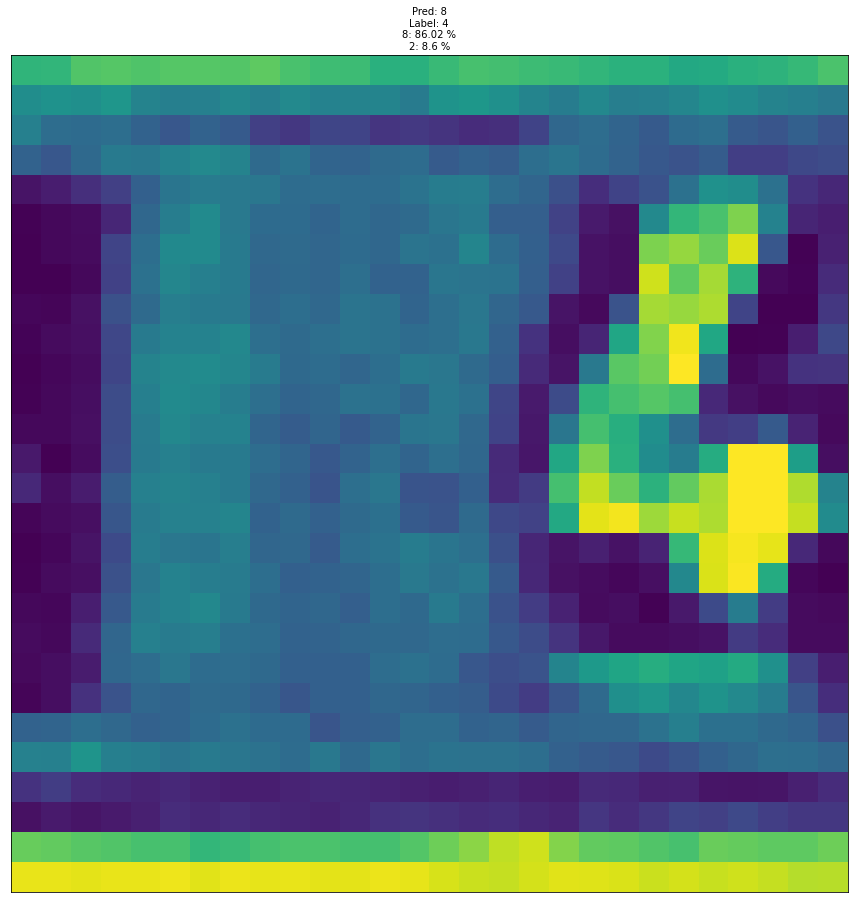

In [53]:
tup = np.asarray(list(zip(all_class_predictions, predictions, labels, images)), dtype=object)
tup = tup[wrongs]

dim = math.ceil(math.sqrt(len(tup)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, (all_class_prediction, prediction, label, img) in enumerate(tup): 
    ax = plt.subplot(rows, cols, (i + 1))
    # ax.get_yaxis().set_visible(False)
    # ax.get_xaxis().set_visible(False)
    # ax.get_xlabel().set_visible_visible(True)
    # ax.set_xlabel()
    # disabling xticks by Setting xticks to an empty list
    plt.xticks([]) 

    # disabling yticks by setting yticks to an empty list
    plt.yticks([]) 
    plt.imshow(img/255.)
    # plt.axis('off')
    plt.title("Pred: " + str(prediction) + "\n" + "Label: " + str(label) + "\n" +
             str(np.argsort(all_class_prediction)[-1]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-1], 2)) + " %" + "\n" + 
             str(np.argsort(all_class_prediction)[-2]) + ": " +
             str(round(sorted(all_class_prediction * 100)[-2], 2))  + " %", fontsize=10)
    # print(softmax(all_class_prediction))
    # print(str(round(np.max(all_class_prediction) * 100, 2)) + " %")
    # plt.xlabel("Pred: " + str(prediction) + " " + "Label: " + str(label), fontsize=8)
plt.show()

# Image prediction

## Clear the folders of results

In [54]:
import glob

### Numberplate

In [55]:
root = "result_2/"

In [56]:
paths = [di for di in glob.glob(root + "*") if os.path.isfile(di)]

In [57]:
paths[:2]

['result_2/196_13695_458.jpg', 'result_2/126_13692_470.jpg']

In [58]:
for filename in paths:
    os.remove(filename)

### Numbers

In [59]:
root = "result_5/"

In [60]:
paths = [di + "/" for di in glob.glob(root + "*") if os.path.isdir(di)]

In [61]:
paths[:2]

['result_5/1/', 'result_5/4/']

In [62]:
for folder in paths:
    filenames = glob.glob(folder + "*.jpg")
    for filename in filenames:
        os.remove(filename)

### Intermediate results

In [63]:
root = "intermediate_results/"

In [64]:
paths = [di + "/" for di in glob.glob(root + "*") if os.path.isdir(di)]

In [65]:
paths[:2]

['intermediate_results/0_balanced_images/',
 'intermediate_results/2_resized_and_sharp_images/']

In [66]:
for folder in paths:
    filenames = glob.glob(folder + "*.jpg")
    for filename in filenames:
        os.remove(filename)

In [67]:
import datetime

from tflite_support.task import core
from tflite_support.task import processor
from helper_functions import *
import cv2
from tqdm import tqdm

In [68]:
VERBOSE = False

In [69]:
#Image paths
SOURCE_IMG_PATH = "./images_2/"
RESULT_IMG_PATH = "result_2/"

#Parameters of object detection
WIDTH = 1000
HEIGHT = 140
DIM = (WIDTH, HEIGHT)
NUM_THREADS = 10
# DETECTOR_PATH = './numberplate_detector.tflite'
DETECTOR_PATH = './object_detector.tflite'

#Parameters of balancing algorithm (Hugh Lines)
balancing_cycles = 3

#Parameters of sharpener algorithm
tb_w = 70
tb_th = 0
tb_blur_size = 10
tb_blur_sigma = 50

#Adaptive threshold and blur
blockSize = 65
k = 0.5

#Contours
h_min = 60
w_min = 25
w_max = 120
x_min = 30
x_max = 400
y_min = 15
y_max = 135
h_w_ratio_max = 3.99
h_w_ratio_min = 1.0


#Tensorflow image classification model
# CHECKPOINT_PATH = "./final/"
# IMG_WIDTH = 28
# IMG_HEIGHT = 28

In [70]:
def analyze(image, detector, filename):

    greyscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Balance image
    balanced_image = balancing_tilted_image(image, greyscale_image, balancing_cycles)
    cv2.imwrite(f'./intermediate_results/0_balanced_images/' + filename, balanced_image)
    # cv2.imread('Imgae', balanced_image)
    # cv2.waitKey(0)
    
    #Object detection and crop detected area
    detected_image = detect_numberplate(detector, balanced_image)
    cv2.imwrite(f'./intermediate_results/1_detected_images/' + filename, detected_image)
    # cv2.imread('Imgae', detected_image)
    # cv2.waitKey(0)

    #Resize and sharpen image
    resized_sharp_image = resize_and_sharpen_image(detected_image, DIM, tb_w, tb_th, tb_blur_size, tb_blur_sigma)
    cv2.imwrite(f'./intermediate_results/2_resized_and_sharp_images/' + filename, resized_sharp_image)
    # cv2.imread('Imgae', resized_sharp_image)
    # cv2.waitKey(0)

    #Niblack threshold and medianblur
    threshold_image = adaptive_threshold_and_median_blur(resized_sharp_image, blockSize, k)
    # cv2.imread('Imgae', threshold_image)
    # cv2.waitKey(0)


    IMG_WIDTH = model.layers[0].input_shape[1]
    IMG_HEIGHT = model.layers[0].input_shape[2]

    #Contours and clip image into 8 pieces
    image_list, threshold_im = find_contours(threshold_image, resized_sharp_image, IMG_WIDTH, IMG_HEIGHT, h_min=h_min, w_min=w_min, w_max=w_max, x_min=x_min, x_max=x_max, h_w_ratio_max=h_w_ratio_max, h_w_ratio_min=h_w_ratio_min, y_min=y_min, y_max=y_max)
    cv2.imwrite(f'./intermediate_results/3_threshold_images/' + filename, threshold_im)
    
    
    # print(tf.image.rgb_to_grayscale(image_list))
    # tensor = tf.convert_to_tensor(image_list)
    tensor = tf.image.rgb_to_grayscale(image_list)
    prediction_array = np.argmax(model.predict(tensor, verbose=False), axis=1)
    prediction_str = ''.join([str(num) for num in prediction_array])
    
    for i, im in enumerate(image_list):
        cv2.imwrite(f'./result_5/{prediction_array[i]}/' + f'_l{i}_' + filename, im)
        # cv2.imread('Imgae', im)
        # cv2.waitKey(0)
    
    return prediction_str, resized_sharp_image, image_list

In [71]:
def normalize_image(image, img_width, img_height):
    # image = image / 255.
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
    return image

In [72]:
base_options = core.BaseOptions(
    file_name=DETECTOR_PATH, use_coral=False, num_threads=NUM_THREADS)
detection_options = processor.DetectionOptions(
    max_results=3, score_threshold=0.1)
options = vision.ObjectDetectorOptions(
    base_options=base_options, detection_options=detection_options)
detector = vision.ObjectDetector.create_from_options(options)


path_list = [SOURCE_IMG_PATH + file for file in os.listdir(SOURCE_IMG_PATH) if '.jpg' in file]
filename_list = [file for file in os.listdir(SOURCE_IMG_PATH) if '.jpg' in file]

skipped_images = []

for i, img_path in tqdm(enumerate(path_list), total=len(path_list)):
    try:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        pred, img, image_list = analyze(image, detector, filename_list[i])
        cv2.imwrite(RESULT_IMG_PATH + f"{i}_" + pred[:-3] + "_" + pred[-3:] + ".jpg", img)

        with open(RESULT_IMG_PATH + "result_images.csv", 'a') as f:
            # f.write(f"{datetime.datetime.now()}, {pred}\n")
            f.write(f"{filename_list[i]}, {pred}\n")
    except Exception as e:
        print(img_path, e)
        skipped_images.append(img_path)
        try:
            cv2.imwrite("Unprocessed_images/" + f"{filename_list[i]}_" + ".jpg", image)
        except Exception as exc:
            print(exc, "--------------")

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
  1%|▍                                          | 3/270 [00:01<01:45,  2.54it/s]

./images_2/2022-11-05T01:45:33_584+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




  3%|█                                          | 7/270 [00:02<01:35,  2.74it/s]

./images_2/2022-11-04T17:27:57_082+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




 24%|██████████▎                               | 66/270 [00:25<01:15,  2.70it/s]

./images_2/2022-11-04T23:05:36_308+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




 32%|█████████████▍                            | 86/270 [00:32<01:06,  2.76it/s]

./images_2/2022-11-04T20:55:33_194+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




 64%|██████████████████████████▎              | 173/270 [01:07<00:37,  2.59it/s]

./images_2/2022-11-05T00:45:33_492+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




 96%|███████████████████████████████████████▍ | 260/270 [01:40<00:03,  2.71it/s]

./images_2/2022-11-04T20:05:33_070+02:00.jpg Traceback (most recent call last):
  File "/home/balazs/Asztal/all_in_one/evaluation/tf_model_evaluation/helper_functions.py", line 182, in find_contours
    image = cv2.resize(image, (img_width, img_height), interpolation=cv2.INTER_LANCZOS4)
cv2.error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'




100%|█████████████████████████████████████████| 270/270 [01:44<00:00,  2.60it/s]


## Display unprocessed images

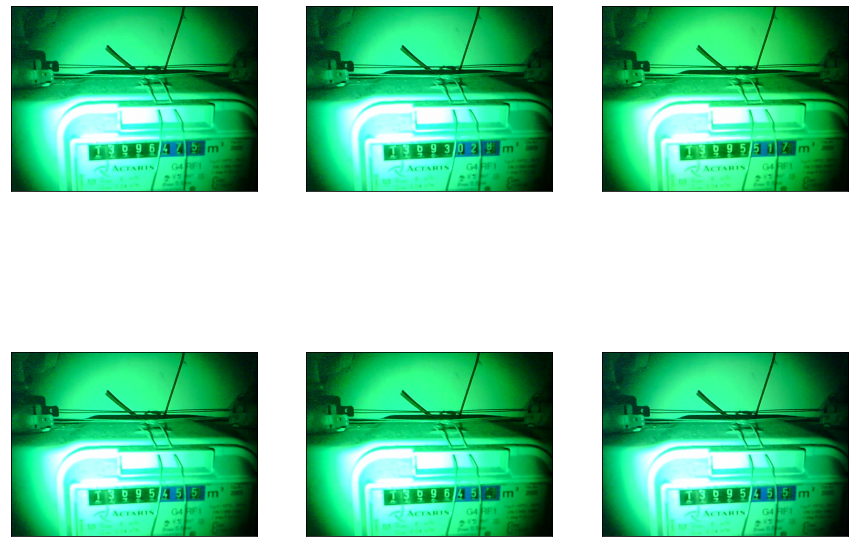

In [73]:
dim = math.ceil(math.sqrt(len(skipped_images)))
rows = dim
cols = dim
fig = plt.figure(figsize=[15, 18])

for i, img_path in enumerate(skipped_images): 
    img = cv2.imread(img_path)
    ax = plt.subplot(rows, cols, (i + 1))
    plt.xticks([]) 
    plt.yticks([]) 
    plt.imshow(img/255.)
plt.show()

# Convert model to .tflite

In [74]:
# converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [75]:
# tflite_model = converter.convert()

In [76]:
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

# Analyzing csv data

## Load csv data

In [95]:
# df = pd.read_csv('./result_2/result_images.csv', header=None)
df = pd.read_csv('./result_2/result_images.csv', header=None)

## Sort data by time 

In [96]:
df_sorted = df.sort_values(by=0)

## Selecting data by value

In [97]:
MIN_VAL = 13688876
MAX_VAL = 13800000
# MIN_VAL = 1
# MAX_VAL = 99999999

In [98]:
df_sorted = df_sorted[df_sorted[1] > MIN_VAL]
df_sorted = df_sorted[df_sorted[1] < MAX_VAL]

In [99]:
df_sorted[1] = df_sorted[1].apply(lambda x: x/1000.)

In [100]:
df_sorted.head(2)

,0,1
123,2022-11-03T19:46:39_304+02:00.jpg,13688.891
83,2022-11-03T19:51:39_158+02:00.jpg,13688.982


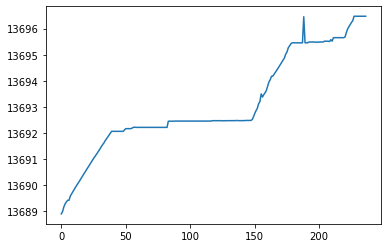

In [101]:
plt.plot(list(df_sorted[1]))
plt.show()

In [102]:
df_sorted

,0,1
123,2022-11-03T19:46:39_304+02:00.jpg,13688.891
83,2022-11-03T19:51:39_158+02:00.jpg,13688.982
174,2022-11-03T19:56:39_297+02:00.jpg,13689.163
223,2022-11-03T20:01:39_155+02:00.jpg,13689.280
249,2022-11-03T20:06:39_166+02:00.jpg,13689.356
...,...,...
179,2022-11-05T01:25:33_606+02:00.jpg,13696.475
230,2022-11-05T01:30:33_597+02:00.jpg,13696.475
137,2022-11-05T01:35:33_565+02:00.jpg,13696.475
49,2022-11-05T01:40:33_609+02:00.jpg,13696.475


## Creating timestamp from filenames

In [103]:
def timestamp_from_date(string) -> int:
    daymonth, time = string[:-10].split('T')
    year, month, day = daymonth.split('-')
    h, m ,sms = time.split(':')
    s, ms = sms.split('_')
    x_datetime = datetime.datetime(int(year),int(month),int(day),int(h),int(m),int(s),int(ms))
    return datetime.datetime.timestamp(x_datetime)

In [104]:
df_sorted["stamp"] = df_sorted[0].apply(timestamp_from_date)

In [105]:
df_sorted['datetime'] = df_sorted['stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))

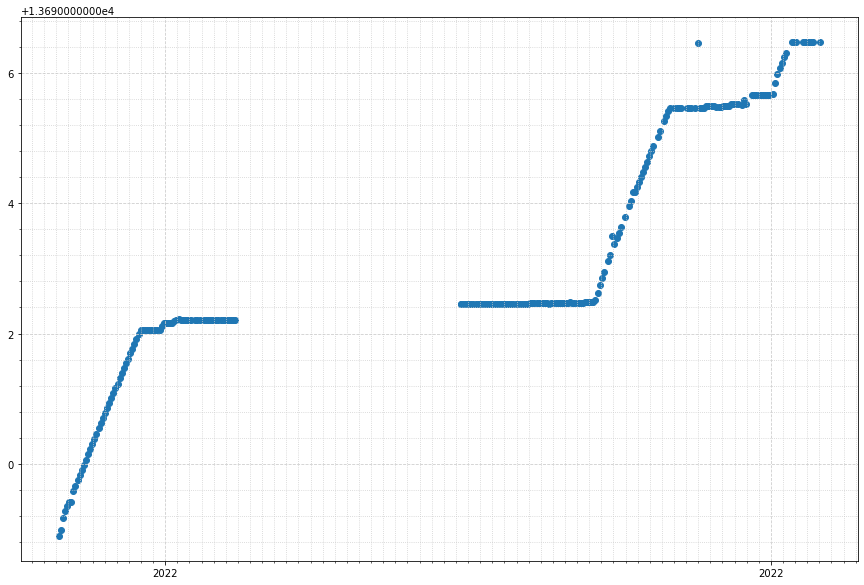

In [106]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)

fig, ax = plt.subplots(figsize=(15, 10))

# Set axis ranges; by default this will put major ticks every 25.
# ax.set_xlim(0, 200)
# ax.set_ylim(0, 200)

# Change major ticks to show every 20.
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(2))

# # Change minor ticks to show every 5. (20/4 = 5)
ax.xaxis.set_minor_locator(AutoMinorLocator(50))
ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# Turn grid on for both major and minor ticks and style minor slightly
# differently.
ax.grid(which='major', color='#CCCCCC', linestyle='--')
ax.grid(which='minor', color='#CCCCCC', linestyle=':')

ax.scatter(df_sorted["datetime"], df_sorted[1])

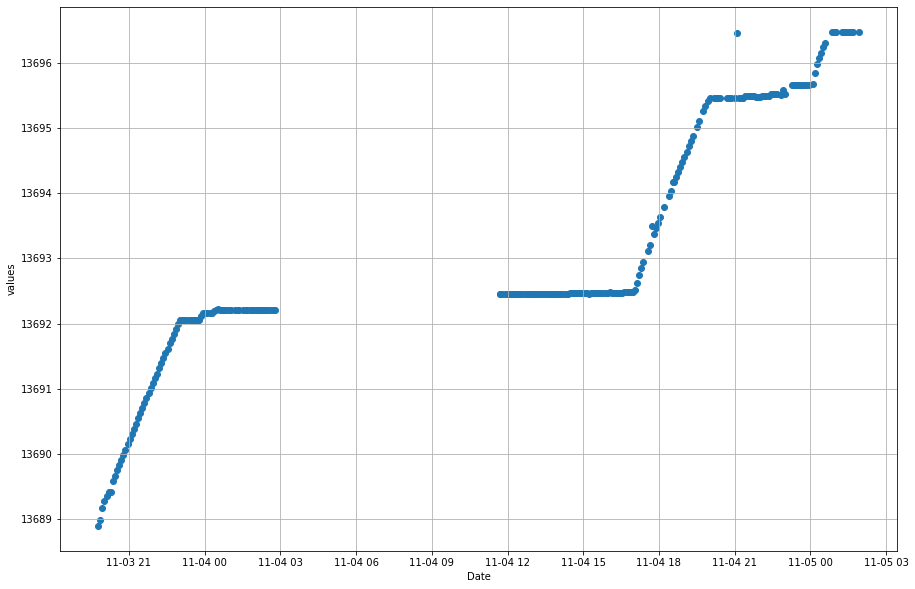

In [107]:
plt.figure(figsize=(15,10))
plt.scatter(df_sorted["datetime"], df_sorted[1])
# for line in daylines:
    # plt.axvline(x = daylines, color = 'gray', label = 'axvline - full height')
    # plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

## Clean data

In [108]:
tu = list(zip(df_sorted[0],list(df_sorted[1])))

In [109]:
tu[0]

('2022-11-03T19:46:39_304+02:00.jpg', 13688.891)

In [110]:
clean = []
for i,t in enumerate(tu):
    if i == 0 or i == len(tu)-1:
        continue
    else:
        current = tu[i][1]
        left_nb = tu[i-1][1]
        right_nb = tu[i+1][1]
        
        diff_left = current- left_nb
        diff_right = right_nb - current
        if diff_left >= 0 and diff_left < 1 and \
            diff_right >= 0 and diff_right < 1:
            clean.append(t)
       

In [111]:
len(tu), len(clean)

(237, 208)

In [112]:
# list(set(tu) - set(clean))

In [113]:
filenames, results = zip(*clean)
print(len(results),"---",len(filenames),"---", results[0],"---", filenames[0])

208 --- 208 --- 13688.982 --- 2022-11-03T19:51:39_158+02:00.jpg


## Create new dataframe with extra columns (year,month,day etc.)

In [114]:
df_cleaned = pd.DataFrame()
df_cleaned["filenames"] = filenames
df_cleaned["measured_values"] = results

In [115]:
df_cleaned["stamp"] = df_cleaned["filenames"].apply(timestamp_from_date)
df_cleaned["year"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).year)
df_cleaned["month"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
df_cleaned["day"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).day)

df_cleaned["hour"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
df_cleaned["minute"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).minute)
df_cleaned["second"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).second)

df_cleaned["ms"] = df_cleaned["stamp"].apply(lambda x: datetime.datetime.fromtimestamp(x).microsecond)

In [116]:
df_cleaned.head()

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms
0,2022-11-03T19:51:39_158+02:00.jpg,13688.982,1.667501e+09,2022,11,3,19,51,39,158
1,2022-11-03T19:56:39_297+02:00.jpg,13689.163,1.667502e+09,2022,11,3,19,56,39,297
2,2022-11-03T20:01:39_155+02:00.jpg,13689.280,1.667502e+09,2022,11,3,20,1,39,155
3,2022-11-03T20:06:39_166+02:00.jpg,13689.356,1.667502e+09,2022,11,3,20,6,39,166
4,2022-11-03T20:11:39_082+02:00.jpg,13689.417,1.667503e+09,2022,11,3,20,11,39,82


In [117]:
date1 = datetime.datetime(2022,10,24,0,0,0)
day1 = datetime.datetime.timestamp(date1)

date2 = datetime.datetime(2022,10,25,0,0,0)
day2 = datetime.datetime.timestamp(date2)

In [118]:
stamps = list(df_cleaned['stamp'])
start_date = datetime.datetime.fromtimestamp(stamps[0])
end_date = datetime.datetime.fromtimestamp(stamps[-1])

In [119]:
date_diff = end_date - start_date

In [120]:
start_date, end_date, date_diff

(datetime.datetime(2022, 11, 3, 19, 51, 39, 158),
 datetime.datetime(2022, 11, 5, 1, 40, 33, 609),
 datetime.timedelta(days=1, seconds=20934, microseconds=451))

In [121]:
date_diff.days

1

In [122]:
daylines = [datetime.datetime.timestamp(start_date)+i*86400 for i in range(date_diff.days + 3)]

In [123]:
daylines[0] - daylines[0] % 86400

1667433600.0

In [124]:
daylines = [stamp - stamp % 86400 for stamp in daylines]

In [125]:
dates = [datetime.datetime.fromtimestamp(stamp) for stamp in daylines]

In [126]:
dates

[datetime.datetime(2022, 11, 3, 1, 0),
 datetime.datetime(2022, 11, 4, 1, 0),
 datetime.datetime(2022, 11, 5, 1, 0),
 datetime.datetime(2022, 11, 6, 1, 0)]

In [127]:
now = datetime.datetime(1970,1,1,1,0,0,0)

In [128]:
datetime.datetime.timestamp(now)

0.0

In [129]:
datetime.date.fromtimestamp(0)

datetime.date(1970, 1, 1)

In [130]:
df_cleaned['datetime'] = df_cleaned['stamp'].apply(lambda x: datetime.datetime.fromtimestamp(x))
df_cleaned['date'] = df_cleaned['stamp'].apply(lambda x: datetime.date.fromtimestamp(x))

In [131]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date
0,2022-11-03T19:51:39_158+02:00.jpg,13688.982,1.667501e+09,2022,11,3,19,51,39,158,2022-11-03 19:51:39.000158,2022-11-03
1,2022-11-03T19:56:39_297+02:00.jpg,13689.163,1.667502e+09,2022,11,3,19,56,39,297,2022-11-03 19:56:39.000297,2022-11-03
2,2022-11-03T20:01:39_155+02:00.jpg,13689.280,1.667502e+09,2022,11,3,20,1,39,155,2022-11-03 20:01:39.000155,2022-11-03
3,2022-11-03T20:06:39_166+02:00.jpg,13689.356,1.667502e+09,2022,11,3,20,6,39,166,2022-11-03 20:06:39.000166,2022-11-03
4,2022-11-03T20:11:39_082+02:00.jpg,13689.417,1.667503e+09,2022,11,3,20,11,39,82,2022-11-03 20:11:39.000082,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...
203,2022-11-05T01:20:33_516+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,20,33,516,2022-11-05 01:20:33.000516,2022-11-05
204,2022-11-05T01:25:33_606+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,25,33,606,2022-11-05 01:25:33.000606,2022-11-05
205,2022-11-05T01:30:33_597+02:00.jpg,13696.475,1.667608e+09,2022,11,5,1,30,33,597,2022-11-05 01:30:33.000597,2022-11-05
206,2022-11-05T01:35:33_565+02:00.jpg,13696.475,1.667609e+09,2022,11,5,1,35,33,565,2022-11-05 01:35:33.000565,2022-11-05


In [132]:
daylines

[1667433600.0, 1667520000.0, 1667606400.0, 1667692800.0]

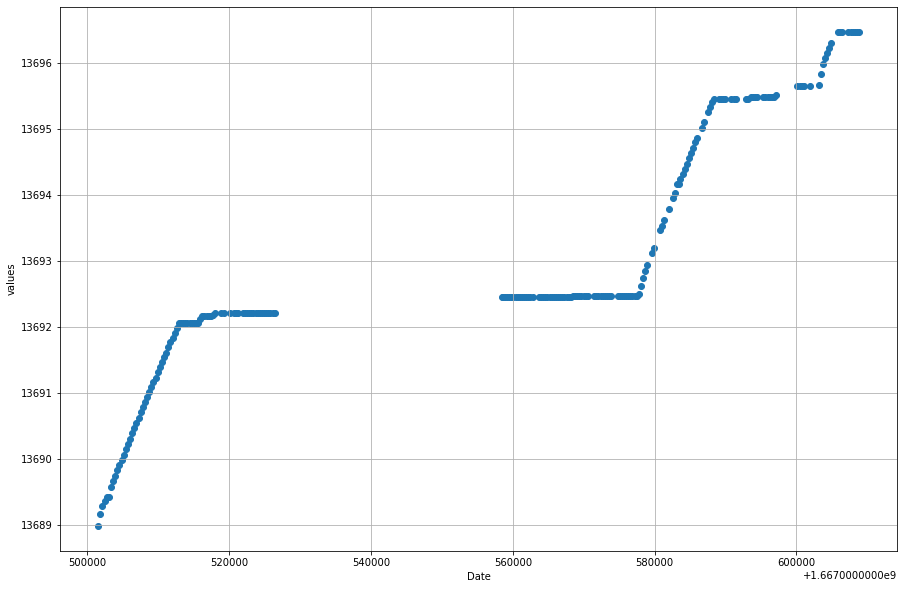

In [133]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['stamp'], df_cleaned['measured_values'])
# for line in daylines:
    # plt.axvline(x = daylines, color = 'gray', label = 'axvline - full height')
    # plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

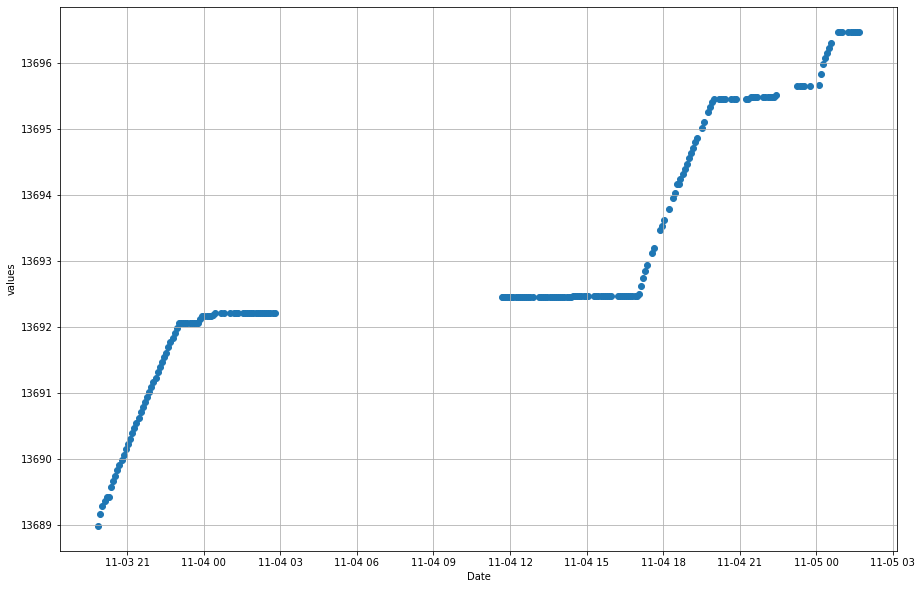

In [134]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['datetime'], df_cleaned['measured_values'])
# for line in daylines:
#     plt.axvline(x = line, color = 'gray', label = 'axvline - full height')
#     plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

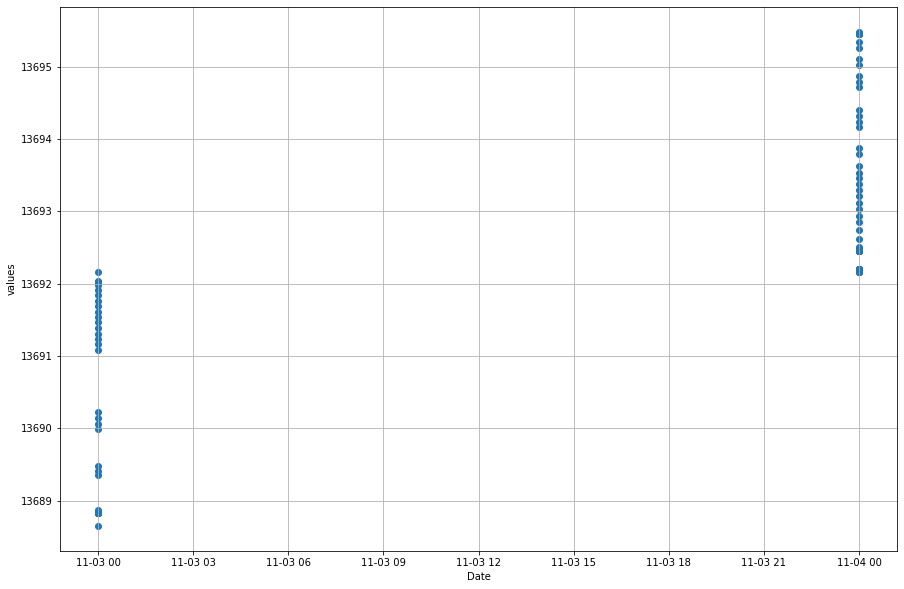

In [327]:
plt.figure(figsize=(15,10))
plt.scatter(df_cleaned['date'], df_cleaned['measured_values'])
# for line in daylines:
#     plt.axvline(x = line, color = 'gray', label = 'axvline - full height')
#     plt.text(10.1,0,'blah',rotation=90)
plt.grid()
plt.xlabel('Date')
plt.ylabel('values')
plt.show()

In [199]:
# df_cleaned[df_cleaned['year']]

In [200]:
df_cleaned['day'].unique()

array([3, 4])

In [201]:
df_cleaned['month'].unique()

array([11])

In [202]:
df_cleaned

,filenames,measured_values,stamp,year,month,day,hour,minute,second,ms,datetime,date
0,2022-11-03T17:57:37_774+02:00.jpg,13688.651,1.667495e+09,2022,11,3,17,57,37,774,2022-11-03 17:57:37.000774,2022-11-03
1,2022-11-03T18:01:39_113+02:00.jpg,13688.651,1.667495e+09,2022,11,3,18,1,39,113,2022-11-03 18:01:39.000113,2022-11-03
2,2022-11-03T18:06:39_184+02:00.jpg,13688.651,1.667495e+09,2022,11,3,18,6,39,184,2022-11-03 18:06:39.000184,2022-11-03
3,2022-11-03T18:11:39_174+02:00.jpg,13688.680,1.667495e+09,2022,11,3,18,11,39,174,2022-11-03 18:11:39.000174,2022-11-03
4,2022-11-03T18:16:39_165+02:00.jpg,13688.785,1.667496e+09,2022,11,3,18,16,39,165,2022-11-03 18:16:39.000165,2022-11-03
...,...,...,...,...,...,...,...,...,...,...,...,...
171,2022-11-04T20:55:33_194+02:00.jpg,13695.455,1.667592e+09,2022,11,4,20,55,33,194,2022-11-04 20:55:33.000194,2022-11-04
172,2022-11-04T21:00:33_216+02:00.jpg,13695.455,1.667592e+09,2022,11,4,21,0,33,216,2022-11-04 21:00:33.000216,2022-11-04
173,2022-11-04T21:10:33_127+02:00.jpg,13695.455,1.667593e+09,2022,11,4,21,10,33,127,2022-11-04 21:10:33.000127,2022-11-04
174,2022-11-04T21:15:33_214+02:00.jpg,13695.455,1.667593e+09,2022,11,4,21,15,33,214,2022-11-04 21:15:33.000214,2022-11-04


In [203]:
import sqlite3

In [204]:
!rm gasmeter_numbers.db

In [205]:
connection = sqlite3.connect("gasmeter_numbers.db")

In [206]:
cursor = connection.cursor()

In [207]:
# CREATE_TABLE = "CREATE TABLE measured_values ( \
#                 filename TEXT, \
#                 measured_values INTEGER, \
#                 timestamp FLOAT,  \
#                 year INTEGER, \
#                 month INTEGER, \
#                 day INTEGER, \
#                 hour INTEGER, \
#                 minute INTEGER, \
#                 second INTEGER)"

In [208]:
# cursor.execute(CREATE_TABLE)

In [209]:
# print(connection.total_changes)

In [210]:
# connection.tables

In [211]:
# con = sqlite3.connect('database.db')
# cursor = con.cursor()
# cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
# print(cursor.fetchall())

In [212]:
# INSERT = "INSERT INTO measured_values VALUES ()"

In [213]:
# for index, row in df_cleaned.iterrows():
#     print(index, row['year'], row['month'])
#     break

In [214]:
df_cleaned.to_sql(name="val", con=connection)

In [215]:
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
SELECT = "SELECT filenames, measured_values, stamp, year, month, day, hour, minute, second FROM val"
WHERE = " WHERE month = 11"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"
# WHERE = " WHERE hour < 12"


In [216]:
result = cursor.execute(SELECT + WHERE ).fetchall()

In [217]:
len(result)

176

In [218]:
df_query = pd.DataFrame(result, columns=list(df_cleaned.columns)[:-1])

ValueError: 11 columns passed, passed data had 9 columns

In [ ]:
df_query

In [ ]:
data = list(df_query['measured_values'])

In [ ]:
plt.plot(data)
plt.show()

In [ ]:
list(df_query.columns)

In [ ]:
 list(df_query['measured_values'])

In [ ]:
# date_start = (2022, 11 , 2)
# date_end = ((2022, 11 , 4))

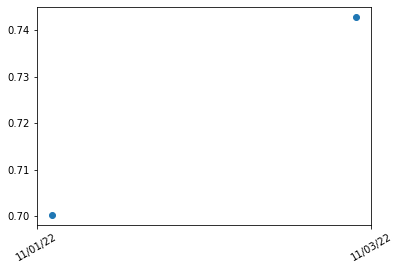

In [121]:
import matplotlib.pyplot as plt
from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)
import numpy as np
import datetime

# Fixing random state for reproducibility
np.random.seed(19680801)


# tick every 5th easter
rule = rrulewrapper(YEARLY, byeaster=1, interval=5)
loc = RRuleLocator(rule)
formatter = DateFormatter('%m/%d/%y')
date1 = datetime.date(2022, 11, 2)
date2 = datetime.date(2022, 11, 4)
delta = datetime.timedelta(days=1)

dates = drange(date1, date2, delta)
s = np.random.rand(len(dates))  # make up some random y values


fig, ax = plt.subplots()
plt.plot_date(dates, s)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=10)

plt.show()


In [137]:
np.array([datetime.datetime.fromtimestamp(stamp) for stamp in df_query['stamp']])

array([datetime.datetime(2022, 11, 2, 19, 5, 44, 127),
       datetime.datetime(2022, 11, 2, 19, 35, 37, 379),
       datetime.datetime(2022, 11, 2, 19, 53, 27, 666),
       datetime.datetime(2022, 11, 2, 21, 53, 19, 541),
       datetime.datetime(2022, 11, 2, 22, 23, 14, 835),
       datetime.datetime(2022, 11, 2, 23, 59, 57, 704),
       datetime.datetime(2022, 11, 3, 13, 32, 26, 765),
       datetime.datetime(2022, 11, 3, 13, 32, 42, 900),
       datetime.datetime(2022, 11, 3, 13, 32, 56, 477),
       datetime.datetime(2022, 11, 3, 13, 33, 12, 918),
       datetime.datetime(2022, 11, 3, 13, 33, 26, 485),
       datetime.datetime(2022, 11, 3, 13, 33, 41, 498),
       datetime.datetime(2022, 11, 3, 13, 33, 56, 481),
       datetime.datetime(2022, 11, 3, 13, 34, 12, 918),
       datetime.datetime(2022, 11, 3, 13, 34, 28, 11),
       datetime.datetime(2022, 11, 3, 13, 34, 41, 473),
       datetime.datetime(2022, 11, 3, 13, 34, 56, 458),
       datetime.datetime(2022, 11, 3, 13, 35, 11, 

In [136]:
datetime.datetime.fromtimestamp(df_query['stamp'][0])

datetime.datetime(2022, 11, 3, 18, 1, 39, 113)

Text(0, 0.5, 'values')

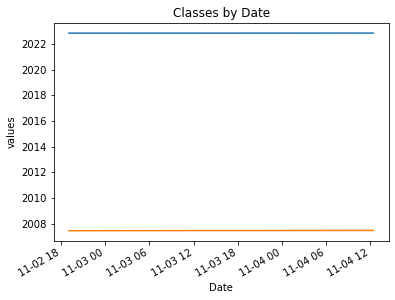

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import numpy as np
 
# Let say we have a dataframe of the days of
# the week and number of classes in each day of the upcoming week.
# Taking 7 days from 1-11-2021 to 7-11-2021
 
dataframe = pd.DataFrame({'date': np.array([datetime.datetime.fromtimestamp(stamp) for stamp in df_query['stamp']]),
                          'values': list(df_query['measured_values'])})
 
# To draw scatter time series plot of the given dataframe
# plt.plot_date(dataframe.date, dataframe.values)
plt.plot(dataframe.date, dataframe.values)
 
# rotating the x-axis tick labels at 30degree towards right
plt.xticks(rotation=30, ha='right')
 
# Giving title to the chart using plt.title
plt.title('Classes by Date')
 
# Providing x and y label to the chart
plt.xlabel('Date')
plt.ylabel('values')

In [142]:
dataframe

,date,values
0,2022-11-02 19:05:44.000127,13683.653
1,2022-11-02 19:35:37.000379,13683.656
2,2022-11-02 19:53:27.000666,13683.936
3,2022-11-02 21:53:19.000541,13686.016
4,2022-11-02 22:23:14.000835,13686.329
...,...,...
329,2022-11-04 12:02:56.000414,13692.453
330,2022-11-04 12:07:56.000437,13692.453
331,2022-11-04 12:12:56.000493,13692.453
332,2022-11-04 12:17:56.000332,13692.453


In [145]:
date = []
for time_val in value:
    date.append(datetime(*time.strptime(time_val, "%m/%d/%Y")[:3]))

fig, ax = plt.subplots()
ax.plot_date(date, value_list)
date_format = mdates.DateFormatter("%m/%d/%Y")
ax.xaxis.set_major_formatter(date_format)
ax.autoscale_view()
title_name = 'plot based on time'
ax.set_title(title_name)
y_label = 'values'
ax.set_ylabel(y_label)
ax.grid(True)

fig.autofmt_xdate()

plt.show()

NameError: name 'value' is not defined

In [303]:
math.exp(-0.1)

0.9048374180359595